## **Using a Convolutional Neural Network to Identify Simulated Nanoparticle Rotations | Regression Model**

In this notebook, a convolutional neural network will be constructed and trained on images of simulated nanoparticles. The aim of the neural network is to correctly identify the rotations of these nanoparticles. TensorFlow2 and Keras will be used to create a classification model.

All of my work can be found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

# Importing the relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from scipy.spatial.transform import Rotation as R

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Creating the dataset.

The images will be loaded in from Google Drive.

In [2]:
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path)

cwd = os.path.join(drive_path, "MyDrive", "Nanoparticles")
folder_name = "Tetras Centred RX 0-90 RY 0-90 Augmented"
direc = os.path.join(cwd, folder_name)

Mounted at /content/drive


The following function creates a Tensorflow dataset from a specified folder. It resizes all images to the specified size and and loads them in as a grayscale image.

In [3]:
def create_dataset(directory, img_size=[64, 64], batch_size=32):
  print("Assigning images to '%s' dataset..." % (directory.split("/")[-1]))
  dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale'
  )
  
  return dataset

The required folder paths are specified, and the training and validation datasets are assigned. 80% of the images in total are used for training, and 20% for validation.

In [4]:
batch_size = 64
img_size = [64, 64] # Image dimensions

training_path = os.path.join(direc, "Train")
validation_path = os.path.join(direc, "Valid")
testing_path = os.path.join(direc, "Test")

In [5]:
train_ds = create_dataset(training_path, img_size=img_size, batch_size=batch_size)
valid_ds = create_dataset(validation_path, img_size=img_size, batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names) # Number of categories

Assigning images to 'Train' dataset...
Found 14112 files belonging to 49 classes.
Assigning images to 'Valid' dataset...
Found 3528 files belonging to 49 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

The pixel values of each image are mapped to a float between 0 and 1. Random zooms are then applied for augmentation to increase the accuracy of the model.

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.Rescaling(1./255, input_shape=(*img_size, 1)),
    # layers.RandomFlip("horizontal",
    #                   input_shape=(*img_size,
    #                               1)),
    # layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Creating the model.

The following function shows the layers of the convolutional neural network.

In [8]:
def get_model(n_outputs):
  model = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(*img_size, 1), name='Convolution_16_3x3'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_1'),
    layers.Conv2D(32, 3, padding='same', activation='relu', name='Convolution_32_3x3'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_2'),
    layers.Conv2D(64, 3, padding='same', activation='relu', name='Convolution_64_3x3'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_3'),
    layers.Dropout(0.2, name='Dropout_20'),
    layers.Flatten(name='Flatten'),
    layers.Dense(img_size[0], activation='relu', kernel_initializer='he_uniform', name='Dense_%s' % img_size[0]),
    layers.Dense(n_outputs, kernel_initializer='he_uniform', name='Dense_%s' % n_outputs)
  ])

  return model

The model is created and compiled using mean squared error for the loss.

In [9]:
model = get_model(num_classes)
model._name = "Nanoparticle_Classification"

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "Nanoparticle_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 1)         0         
                                                                 
 Convolution_16_3x3 (Conv2D)  (None, 64, 64, 16)       160       
                                                                 
 Max_Pooling_2x2_Stride_2_1   (None, 32, 32, 16)       0         
 (MaxPooling2D)                                                  
                                                                 
 Convolution_32_3x3 (Conv2D)  (None, 32, 32, 32)       4640      
                                                                 
 Max_Pooling_2x2_Stride_2_2   (None, 16, 16, 32)       0         
 (MaxPooling2D)                                                  
                                                                 
 Convolution_64_3x3 (Conv2D)  (None, 16

# Training the model.

The model is trained for 50 epochs.

In [10]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/50
221/221 [==============================] - 1432s 2s/step - loss: 1.5362 - accuracy: 0.5636 - val_loss: 0.2245 - val_accuracy: 0.9110
Epoch 2/50
221/221 [==============================] - 51s 232ms/step - loss: 0.2357 - accuracy: 0.9050 - val_loss: 0.1426 - val_accuracy: 0.9172
Epoch 3/50
221/221 [==============================] - 51s 232ms/step - loss: 0.1774 - accuracy: 0.9201 - val_loss: 0.1757 - val_accuracy: 0.9206
Epoch 4/50
221/221 [==============================] - 51s 233ms/step - loss: 0.1607 - accuracy: 0.9223 - val_loss: 0.1348 - val_accuracy: 0.9201
Epoch 5/50
221/221 [==============================] - 51s 233ms/step - loss: 0.1482 - accuracy: 0.9234 - val_loss: 0.1386 - val_accuracy: 0.9189
Epoch 6/50
221/221 [==============================] - 52s 233ms/step - loss: 0.1402 - accuracy: 0.9268 - val_loss: 0.1376 - val_accuracy: 0.9195
Epoch 7/50
221/221 [==============================] - 51s 233ms/step - loss: 0.1323 - accuracy: 0.9281 - val_loss: 0.1670 - val_acc

Visualising the training results.

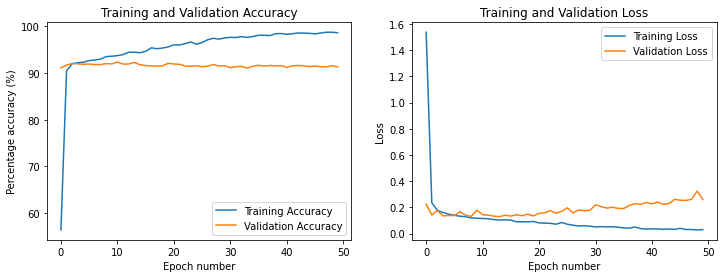

In [11]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc * 100, label='Training Accuracy')
plt.plot(epochs_range, val_acc * 100, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch number")
plt.ylabel("Percentage accuracy (%)")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

# Predicting an image.

The rotations are applied to the nanoparticles using 3x3 rotation matrices. The Gram–Schmidt process can then be used to represent this 3x3 matrix in 6D. The following function converts this 6D representation back into a matrix from which the Euler angles can be calculated.

In [12]:
def calculate_euler(label):
  rotation = np.asarray(label).reshape((2, 3)).T
  v1 = rotation[:, 0]
  v2 = rotation[:, 1]

  e1 = v1 / np.linalg.norm(v1)

  u2 = v2 - ((e1 * v2) * e1)
  e2 = u2 / np.linalg.norm(u2)

  e3 = np.cross(e1, e2) 

  rotation = np.vstack((e1, e2, e3)).T
  rotation_euler = R.from_matrix(rotation).as_euler("xyz", degrees=True)

  return rotation_euler

The following function adds an entry to the prediction dictionary (used to sort and analyse the results from the model's predictions) if it does not exist, or adds the value to the corresponding key otherwise.

In [13]:
def add_to_predict_dict(prediction_dict, key, value):
  try:
    prediction_dict[key] += value
  except KeyError:
    prediction_dict[key] = value

  return prediction_dict

The following function takes an image path as an input and also the prediction dictionary. It then uses the neural network to predict the image and adds that prediction to the dictionary.

In [14]:
rx_names = []
ry_names = []

def predict_image(img_path, prediction_dict):
  img = tf.keras.utils.load_img(
      img_path, target_size=img_size, color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  prediction = json.loads(class_names[np.argmax(score)])

  # Format: Shape W RX RY RZ
  img_name_split = img_path.split("/")[-1].split() # Splits file name of image up
  
  actual_rx = img_name_split[2]
  if actual_rx not in rx_names:
    rx_names.append(actual_rx)

  actual_ry = img_name_split[3]
  if actual_ry not in ry_names:
    ry_names.append(actual_ry)

  prediction = calculate_euler(prediction)

  predicted_rx = "RX%s" % int(prediction[0])
  predicted_ry = "RY%s" % int(prediction[1])

  # print("Actual: \t%s \t| Predicted: \t%s" % (actual_rx, predicted_rx))

  # Append the results to the prediction dictionary
  dif_rx = abs(int(actual_rx[2:]) - int(predicted_rx[2:]))
  prediction_dict = add_to_predict_dict(prediction_dict, actual_rx + " DIF", dif_rx)
  prediction_dict = add_to_predict_dict(prediction_dict, actual_rx + " TOT", 1)

  dif_ry = abs(int(actual_ry[2:]) - int(predicted_ry[2:]))
  prediction_dict = add_to_predict_dict(prediction_dict, actual_ry + " DIF", dif_ry)
  prediction_dict = add_to_predict_dict(prediction_dict, actual_ry + " TOT", 1)

  return prediction_dict

In [15]:
predict_dictionary = {}

for rotation in os.listdir(testing_path):
  rotation_path = os.path.join(testing_path, rotation)
  for img in os.listdir(rotation_path):
    img_path = os.path.join(rotation_path, img)
    predict_dictionary = predict_image(img_path, predict_dictionary)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/transform/rotation.py:135: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  warnings.warn("Gimbal lock detected. Setting third angle to zero since"


The results from the prediction dictionary will be represented as percentages as well as absolute difference between the true rotation of the nanoparticle and the predicted rotation.

In [16]:
def calculate_percentage_correct(rotation_key):
  temp_dif = predict_dictionary[rotation_key + " DIF"]
  total = predict_dictionary[rotation_key + " TOT"]

  dif = temp_dif / total

  return dif

In [17]:
dif_x = []
dif_y = []

for rx in rx_names:
  dif_x.append(calculate_percentage_correct(rx))

for ry in ry_names:
  dif_y.append(calculate_percentage_correct(ry))

Sorting the results in order of increasing angle.

In [18]:
ordered_rx = []
ordered_ry = []

for rotation in rx_names:
  ordered_rx.append(int(rotation[2:]))

order_x = list(np.argsort(np.asarray(ordered_rx)))
ordered_names_x = np.array(rx_names)[order_x]
ordered_dif_x = np.array(dif_x)[order_x]

for rotation in ry_names:
  ordered_ry.append(int(rotation[2:]))

order_y = list(np.argsort(np.asarray(ordered_ry)))
ordered_names_y = np.array(ry_names)[order_y]
ordered_dif_y = np.array(dif_y)[order_y]

Visualising how accurately the model predicts rotations.

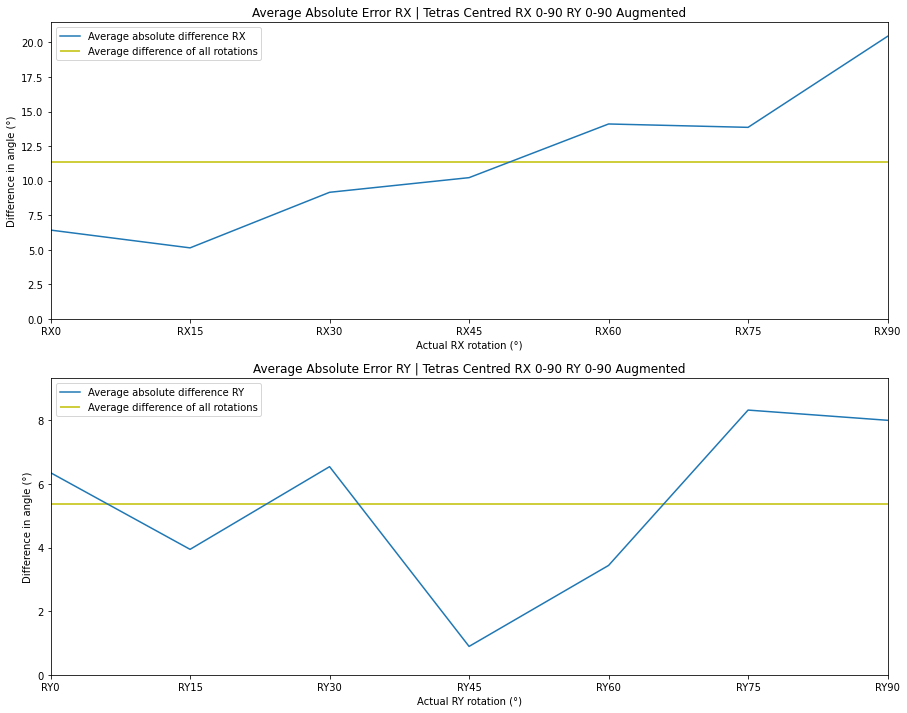

In [19]:
bar_width = 0.2 
x = np.arange(len(ordered_names_x))

plt.figure(figsize=(15, 12))
plt.subplot(211)
plt.plot(x, ordered_dif_x, label="Average absolute difference RX")
plt.hlines(np.mean(ordered_dif_x), x[0]-bar_width, x[-1]+bar_width,
           color="y", label = "Average difference of all rotations")
plt.xlabel("Actual RX rotation (°)")
plt.xticks(x, ordered_names_x)
plt.ylabel("Difference in angle (°)")
plt.xlim([x[0], x[-1]])
plt.ylim([0, np.max(ordered_dif_x) + 1])
plt.legend(loc="best")
plt.title("Average Absolute Error RX | %s" % folder_name)

plt.subplot(212)
plt.plot(x, ordered_dif_y, label="Average absolute difference RY")
plt.hlines(np.mean(ordered_dif_y), x[0]-bar_width, x[-1]+bar_width,
           color="y", label = "Average difference of all rotations")
plt.xlabel("Actual RY rotation (°)")
plt.xticks(x, ordered_names_y)
plt.ylabel("Difference in angle (°)")
plt.xlim([x[0], x[-1]])
plt.ylim([0, np.max(ordered_dif_y) + 1])
plt.legend(loc="best")
plt.title("Average Absolute Error RY | %s" % folder_name)

plt.show()